In [18]:
!pip install -U keras

In [19]:
import os

# os.environ["KERAS_BACKEND"] = "torch"

import keras
# import keras.backend as K
# K.set_backend("torch")


import glob

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, Subset

In [20]:
feature_columns = [
    # 'LeftWristX', 'LeftWristY', 'LeftWristZ', 
    # 'LeftElbowX', 'LeftElbowY', 'LeftElbowZ', 
    # 'LeftShoulderX', 'LeftShoulderY', 'LeftShoulderZ', 
    'LeftElbowYaw', 'LeftElbowRoll', 'LeftShoulderRoll', 'LeftShoulderPitch',
    'origin_x', 'origin_y', 'origin_z',
    'goal_x', 'goal_y', 'goal_z'
]
output_columns = [
    'LeftElbowYaw', 'LeftElbowRoll', 'LeftShoulderRoll', 'LeftShoulderPitch'
]

# data_folder = glob.glob(r"..\NaoPickAndPlaceDat\*\processed_step_5.csv")
data_folder = glob.glob("../NaoPickAndPlaceDataNew/*/processed_step_5.csv")

feature_shape = (3, len(feature_columns))  # (window, features)
label_shape = (1, 1)  # (window, features)

cache_base_dir = "NaoCache"

column_ranges = {
    'LeftElbowYaw': (-120, 120), 'LeftElbowRoll': (-90, 0),
    'RightElbowYaw': (-120, 120), 'RightElbowRoll': (0, 90),
    'LeftShoulderRoll': (-45, 90), 'LeftShoulderPitch': (-120, 120),
    'RightShoulderRoll': (-90, 45), 'RightShoulderPitch': (-120, 120),
    # 'LeftElbowYawCos': (-1, 1), 'LeftElbowRollCos': (-1, 1),
    # 'RightElbowYawCos': (-1, 1), 'RightElbowRollCos': (-1, 1),
    # 'LeftShoulderRollCos': (-1, 1), 'LeftShoulderPitchCos': (-1, 1),
    # 'RightShoulderRollCos': (-1, 1), 'RightShoulderPitchCos': (-1, 1),
    # 'LeftElbowYawSin': (-1, 1), 'LeftElbowRollSin': (-1, 1),
    # 'RightElbowYawSin': (-1, 1), 'RightElbowRollSin': (-1, 1),
    # 'LeftShoulderRollSin': (-1, 1), 'LeftShoulderPitchSin': (-1, 1),
    # 'RightShoulderRollSin': (-1, 1), 'RightShoulderPitchSin': (-1, 1),
    'LeftWristX': (-1, 1), 'LeftWristY': (-1, 1), 'LeftWristZ': (0, 3),
    'RightWristX': (-1, 1), 'RightWristY': (-1, 1), 'RightWristZ': (0, 3),
    'LeftElbowX': (-1, 1), 'LeftElbowY': (-1, 1), 'LeftElbowZ': (0, 3),
    'RightElbowX': (-1, 1), 'RightElbowY': (-1, 1), 'RightElbowZ': (0, 3),
    'LeftShoulderX': (-1, 1), 'LeftShoulderY': (-1, 1), 'LeftShoulderZ': (0, 3),
    'RightShoulderX': (-1, 1), 'RightShoulderY': (-1, 1), 'RightShoulderZ': (0, 3),
    'origin_x': (0, 640), 'origin_y': (0, 480), 'origin_z': (0, 7),
    'goal_x': (0, 640), 'goal_y': (0, 480), 'goal_z': (0, 7),
    # 'LeftWristX_PX': (0, 640), 'LeftWristY_PX': (0, 480),
    # 'RightWristX_PX': (0, 640), 'RightWristY_PX': (0, 480),
    # 'LeftElbowX_PX': (0, 640), 'LeftElbowY_PX': (0, 480),
    # 'RightElbowX_PX': (0, 640), 'RightElbowY_PX': (0, 480),
    # 'LeftShoulderX_PX': (0, 640), 'LeftShoulderY_PX': (0, 480),
    # 'RightShoulderX_PX': (0, 640), 'RightShoulderY_PX': (0, 480),
    # 'WristBallDistance': (0, 800), 'WristBoxDistance': (0, 800), 'BallBoxDistance': (0, 800)
}

In [ ]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Ensure model and tensors move to GPU
model.to(device)


def normalize_columns(df):
    for column, (min_val, max_val) in column_ranges.items():
        df[column] = (df[column] - min_val) / (max_val - min_val)
        if min_val < 0:
            df[column] = 2 * df[column] - 1
    return df


class CustomDataset(Dataset):
    def __init__(self, data_folder, feature_columns, output_columns, label_shape, is_grasped):
        self.data_folder = data_folder
        self.feature_columns = feature_columns
        self.output_columns = output_columns
        self.label_shape = label_shape
        self.is_grasped = is_grasped
        self.data = list(self.generator())

    def generator(self):
        for file in self.data_folder:
            df = pd.read_csv(file)
            df = df.dropna()
            df = normalize_columns(df)
            
            # Filter based on is_grasped
            if self.is_grasped is not None:
                df = df[df['is_grasped'] == self.is_grasped]

            selected_features = df[self.feature_columns].values.astype(np.float64)
            raw_data = df[self.output_columns].values.astype(np.float64)

            min_skip = 1
            num_data = len(df)
            for skip in range(5, 100, 10):
                for i in range(0, num_data - 1):
                    if i < (feature_shape[0] - 1) * skip:
                        features = selected_features[:i + 1][::-1][::skip][::-1]
    
                        num_rows, num_columns = features.shape
                        num_rows_to_add = feature_shape[0] - num_rows
                        new_rows_array = np.full((num_rows_to_add, num_columns), 0)
                        features = np.concatenate((new_rows_array, features), axis=0)
                        next_is_grasped = df['is_grasped'].values[:i + 1][::-1][::skip][0]
                    else:
                        features = selected_features[i - ((feature_shape[0] - 1) * skip):i + 1][::-1][::skip][::-1]
                        next_is_grasped = df['is_grasped'].values[i - ((feature_shape[0] - 1) * skip):i + 1][::-1][::skip][0]

                    diff = 0 if i + skip < num_data - 1 else -len(df) + i + skip + 2
                    next_label = raw_data[i + 1 + skip - diff:i + 1 + skip - diff + self.label_shape[0]]
                    labels = next_label
                    labels = labels.squeeze(0)

                    labels = torch.tensor(labels, dtype=torch.float64, device=device)

                    # new_features = np.concatenate((features, np.ones((feature_shape[0], 1)) + skip - 1), axis=1)

                    yield [torch.tensor(features, dtype=torch.float64, device=device), torch.tensor(skip, dtype=torch.int16, device=device), torch.tensor(next_is_grasped, dtype=torch.int16, device=device)], labels
                # current_label = raw_data[i:i + self.label_shape[0]]
                # for skip in range(min_skip, 26):
                #     diff = 0 if i + skip < len(df) - 1 else -len(df) + i + skip + 2
                #     next_label = raw_data[i + 1 + skip - diff:i + 1 + skip - diff + self.label_shape[0]]
                #     labels = next_label
                #     labels = labels.squeeze(0)
                #     min_skip = skip
                #     if abs((next_label - current_label)[0]).sum() > 0.1:
                #         break
                # labels = torch.tensor(labels, dtype=torch.float64, device=device)
                # yield torch.tensor(features, dtype=torch.float64, device=device), labels
                # yield torch.tensor(np.repeat(selected_features[i:i + 1], feature_shape[0], axis=0), dtype=torch.float64, device=device), labels

    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return len(self.data)



def create_dataset(data_folder, output_columns, label_shape, is_grasped, cache_path=None):
    if cache_path and os.path.exists(cache_path):
        dataset = torch.load(cache_path)
    else:
        dataset = CustomDataset(data_folder, feature_columns, output_columns, label_shape, is_grasped)
        # if cache_path:
        #     torch.save(dataset, cache_path)

    return dataset

Using device: cuda


NameError: name 'model' is not defined

In [ ]:
def split_dataset(dataset, train_size, batch_size, shuffle=True):
    dataset_size = len(dataset)
    train_size = int(dataset_size * train_size)

    indices = list(range(dataset_size))
    train_indices = indices[:train_size]
    val_indices = indices[train_size:]

    train_dataset = Subset(dataset, train_indices)
    val_dataset = Subset(dataset, val_indices)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

In [ ]:
def train_model_for_output(data_folder, output_column, feature_shape, label_shape, is_grasped, cache_dir, split_ratio=0.8, batch_size=4096):
    # Create dataset for the specific output
    dataset = create_dataset(data_folder, [output_column], label_shape, is_grasped, cache_path=cache_dir)
    dataset_train, dataset_val = split_dataset(dataset, split_ratio, batch_size)
    
    initializer = keras.initializers.GlorotUniform(seed=42)

    # Input layers
    input_layer = keras.layers.Input(shape=feature_shape)
    step_input = keras.layers.Input(shape=(1,))
    is_grasped_input = keras.layers.Input(shape=(1,))
    
    n = 64
    
    # LSTM Layer with Attention
    lstm_out = keras.layers.LSTM(n * 4, return_sequences=False, 
                                                           kernel_initializer=initializer)(input_layer)
    
    step_embedding = keras.layers.Embedding(input_dim=100, output_dim=n)(step_input)
    is_grasped_embedding = keras.layers.Embedding(input_dim=3, output_dim=n)(is_grasped_input)
    
    # Flatten embeddings to concatenate with LSTM output
    step_embedding_flat = keras.layers.Flatten()(step_embedding)
    is_grasped_embedding_flat = keras.layers.Flatten()(is_grasped_embedding)

    # Concatenate step input and is_grasped_input
    x = keras.layers.Concatenate()([lstm_out, step_embedding_flat, is_grasped_embedding_flat])
    
    # Output layer
    output_layer = keras.layers.Dense(label_shape[0], activation='linear', kernel_initializer=initializer)(x)
    
    # Create and compile the model
    model = keras.models.Model(inputs=[input_layer, step_input, is_grasped_input], outputs=output_layer)
    model.compile(optimizer=keras.optimizers.AdamW(learning_rate=0.001, clipnorm=1.0),
                  loss='mse', metrics=['mae'])
    
    # Print model summary
    model.summary()

    # Callbacks
    lr_reducer = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=15, min_lr=0.0000001)
    early_stop = keras.callbacks.EarlyStopping(monitor='loss', patience=50, min_delta=1e-5, verbose=1, restore_best_weights=True)
    prefix = 'all' if is_grasped is None else 'grasp' if is_grasped == -1 else 'drop'
    model_checkpoint = keras.callbacks.ModelCheckpoint(f"best_model_{output_column}_{prefix}.keras", monitor='val_loss', verbose=1, save_best_only=True, mode='min', initial_value_threshold=1.0)
    
    # Train the model
    history = model.fit(dataset_train, validation_data=dataset_val, epochs=3000, callbacks=[lr_reducer, early_stop, model_checkpoint])
    
    # Plot training and validation losses
    plt.plot(np.log(history.history['loss']), label='Training Log Loss')
    plt.plot(np.log(history.history['val_loss']), label='Validation Log Loss')
    plt.title(f'Training and Validation Loss for {output_column}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    torch.cuda.empty_cache()

In [ ]:
for output_column in output_columns:
    # for is_grasped in [1, -1]:
    for is_grasped in [None]:
        cache_dir = f"{cache_base_dir}_{output_column}"
        train_model_for_output(data_folder, output_column, feature_shape, label_shape, is_grasped, cache_dir)

ValueError: num_samples should be a positive integer value, but got num_samples=0

In [ ]:
def restore_scale(predictions, label_ranges):
    restored_predictions = []
    for i, label in enumerate(label_ranges.keys()):
        min_val, max_val = label_ranges[label]
        normalized_value = predictions[0]

        if min_val < 0:
            original_value = ((normalized_value + 1) / 2) * (max_val - min_val) + min_val
        else:
            original_value = normalized_value * (max_val - min_val) + min_val

        restored_predictions.append(original_value)
    return np.array(predictions)
    
def calculate_prediction(dataset, model, label_ranges):
    all_predictions = {label: [] for label in label_ranges.keys()}
    all_actuals = {label: [] for label in label_ranges.keys()}

    for batch_data in dataset:
        features = batch_data[0]
        labels = batch_data[1].cpu().detach().numpy()

        predictions = np.array([p.cpu().detach().numpy() for p in model(features)])
        for i in range(len(features[0])):
            if features[1][i].cpu() != 5:
                continue
            restored_predictions = restore_scale(predictions[i], label_ranges)
            actual_labels = labels[i]
            restored_actual_labels = restore_scale(actual_labels, label_ranges)

            for j, label in enumerate(label_ranges.keys()):
                all_predictions[label].append(restored_predictions[j])
                all_actuals[label].append(restored_actual_labels[j])
    
    return all_predictions, all_actuals

def plot_predictions(predications, actuals):
    for label in predications.keys():
        plt.figure()
        
        plt.plot(actuals[label], label='Actual', linestyle='--')
        
        plt.plot(predications[label], label='Prediction')
        
        # Set plot details
        plt.title(f'Prediction vs Actual for {label}')
        plt.xlabel('Data Point Index')
        plt.ylabel('Value')
        plt.legend()
        plt.show()

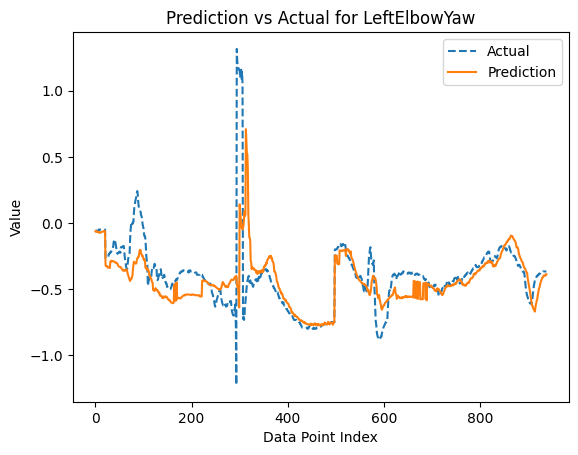

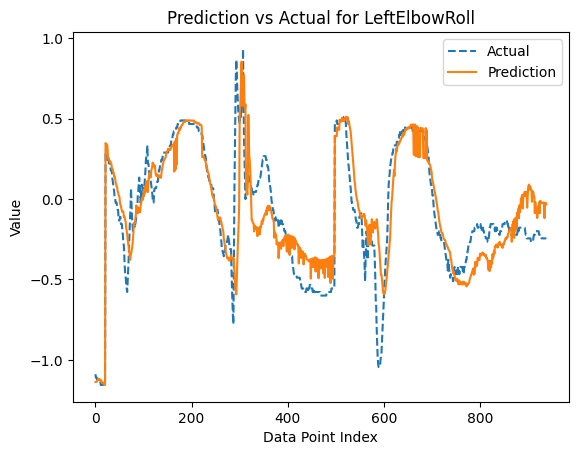

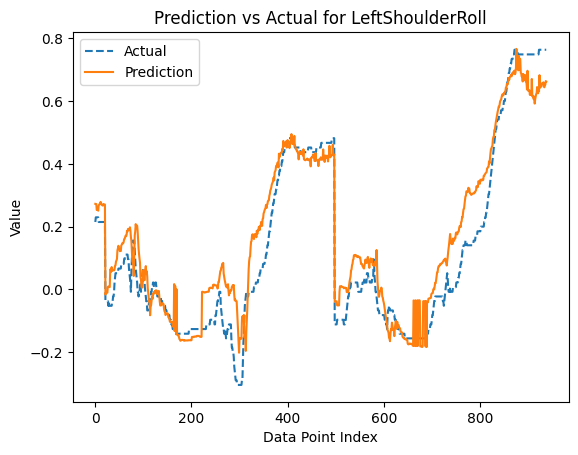

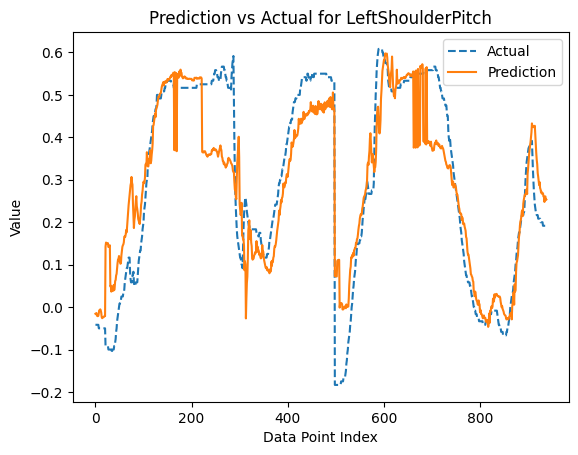

In [ ]:
for output_column in output_columns:
    for is_grasped in [None]:
    # for is_grasped in [1, -1]:
        prefix = 'all' if is_grasped is None else'grasp' if is_grasped == -1 else 'drop'
        model = keras.models.load_model(f"best_model_{output_column}_{prefix}.keras")
        label_ranges = {column: column_ranges[column] for column in [output_column] if column in column_ranges}
        dataset = create_dataset(data_folder, [output_column], label_shape, is_grasped, cache_path=f"NaoCache_{output_column}")
        dataset_train, dataset_val = split_dataset(dataset, 0.8, 1024, False)
        predications, actuals = calculate_prediction(dataset_val, model, label_ranges)
        plot_predictions(predications, actuals)